# Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from cv2 import cvtColor, COLOR_BGR2RGB, COLOR_LAB2RGB
import sys

#sys.path.append('../scripts/')
#from util import LABtoRGB


# Load dataset

In [2]:
ab1 = np.load("../data/image-colorization/ab/ab/ab1.npy")
ab2 = np.load("../data/image-colorization/ab/ab/ab2.npy")
ab3 = np.load("../data/image-colorization/ab/ab/ab3.npy")
l = np.load("../data/image-colorization/l/gray_scale.npy")

In [3]:
# Concatenate the numpy files
ab = np.concatenate((ab1,ab2,ab3),axis=0)

In [5]:
print(ab.shape)
print(l.shape)

(25000, 224, 224, 2)
(25000, 224, 224)


(224, 224, 3)


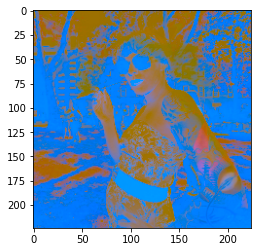

In [32]:
img_lab = np.concatenate((ab[0],l[0][:,:,None]),axis=2)
print(img_lab.shape)
plt.imshow(cvtColor(img_lab,COLOR_LAB2RGB))

In [ ]:
print()